In [1]:
import django_initializer
from telemetry.fast_lap_analyzer import FastLapAnalyzer
from telemetry.racing_stats import RacingStats
from telemetry.models import FastLap, Lap
from telemetry.analyzer import Analyzer
from telemetry.influx import Influx
import plotly.io as pio

pio.renderers.default = "svg"  # comment this line to use interactive plots

import pandas as pd
import numpy as np

from telemetry.visualizer import *

%load_ext autoreload
%autoreload 2

analyzer = Analyzer()
influx = Influx()
fast_lap_analyzer = FastLapAnalyzer()
racing_stats = RacingStats()

2023-09-01 13:51:25,248 DEBUG Influx: Connected to https://telemetry.b4mad.racing/


In [2]:
kwargs = {
    "game": "iRacing",
    # "game": "Assetto Corsa Competizione",
    # "track": "oschersleben gp",
    # "track": "aragon gp",
    # "track": "jerez gp",
    # "track": "spa up",
    "track": "okayama short",
    # "track": "Hungaroring:track config",
    # "car": "Ferrari 488 GT3 Evo 2020",
    # "car": "GT3",
    "car": "Mazda MX-5 Cup",
    "valid": True,
}
laps = racing_stats.laps(**kwargs)
laps = laps[:10]
# laps = list(laps)
fast_lap_analyzer.laps = laps
data_frames, laps_with_telemetry = fast_lap_analyzer.fetch_lap_telemetry()

2023-09-01 13:51:25,341 DEBUG Influx: Connected to https://telemetry.b4mad.racing/
2023-09-01 13:51:25,346 INFO Fetching telemetry for iRacing - okayama short - Mazda MX-5 Cup
2023-09-01 13:51:25,346 INFO   track.id 1029 car.id 15
2023-09-01 13:51:25,346 INFO   session 1690362827 lap.id 235802 number 5
2023-09-01 13:51:25,346 INFO   length 1928 time 60.1182 valid True
2023-09-01 13:51:25,347 INFO   start 2023-07-26 04:18:07.922038+00:00 end 2023-07-26 04:19:08.049835+00:00
2023-09-01 13:51:25,669 INFO Fetching telemetry for iRacing - okayama short - Mazda MX-5 Cup
2023-09-01 13:51:25,669 INFO   track.id 1029 car.id 15
2023-09-01 13:51:25,669 INFO   session 1690362827 lap.id 235804 number 6
2023-09-01 13:51:25,669 INFO   length 1929 time 60.1341 valid True
2023-09-01 13:51:25,670 INFO   start 2023-07-26 04:19:08.049835+00:00 end 2023-07-26 04:20:08.205594+00:00
2023-09-01 13:51:25,987 INFO Fetching telemetry for iRacing - okayama short - Mazda MX-5 Cup
2023-09-01 13:51:25,987 INFO   tra

In [3]:
# influx_data_frames = []
# for df in data_frames:
#     influx_data_frames.append(df.copy())

# data_frames = []
# for df in influx_data_frames:
#     data_frames.append(df.copy())

In [4]:
current_sectors = fast_lap_analyzer.current_fast_lap_sectors()
display(current_sectors)

[{'start': 0, 'end': 321},
 {'start': 322, 'end': 575},
 {'start': 576, 'end': 770},
 {'start': 771, 'end': 1003},
 {'start': 1004, 'end': 1308},
 {'start': 1309, 'end': 1929}]

2023-09-01 13:51:28,367 DEBUG split_sectors: min_length_throttle_below_threshold: 20
2023-09-01 13:51:28,368 DEBUG split_sectors: min_distance_between_sectors: 35
2023-09-01 13:51:28,369 DEBUG sector 2 - 593m too short: 4.0


[{'start': 0, 'end': 321.0, 'length': 321},
 {'start': 322.0, 'end': 578.0, 'length': 256},
 {'start': 579, 'end': 770.0, 'length': 191},
 {'start': 771.0, 'end': 1003.0, 'length': 232},
 {'start': 1004, 'end': 1308.0, 'length': 304},
 {'start': 1309.0, 'end': 1928.57, 'length': 619}]

2023-09-01 13:51:28,370 DEBUG start_diffs: [0, 0.0, 3, 0.0, 0, 0.0] med: 0.5


'Sectors are similar: True'

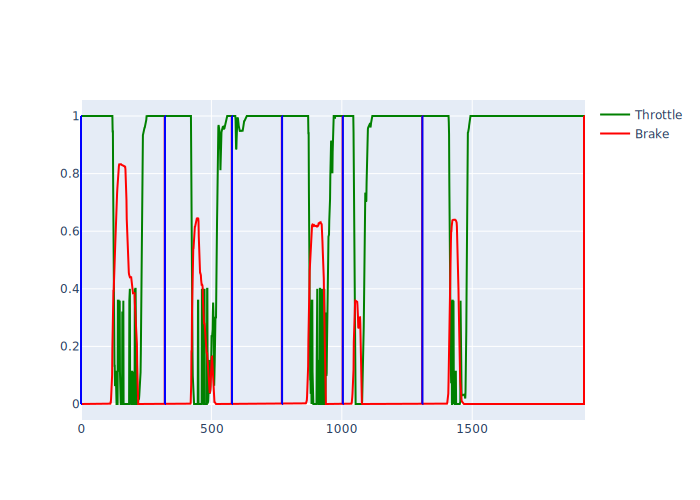

In [5]:
# for i, df in enumerate(data_frames):
#     fig = lap_fig(df, full_range=True, columns=["Throttle"])
#     fig.show()
sector_start_end, df_max = fast_lap_analyzer.extract_sectors(data_frames)
display(sector_start_end)

# are the sectors similar to the current fast lap?
similarity = fast_lap_analyzer.similar_sectors(sector_start_end, current_sectors)
display(f"Sectors are similar: {similarity}")

fig = lap_fig(df_max, full_range=True, columns=["Throttle", "Brake"])
# add a vertical line for each sector
for i, sector in enumerate(sector_start_end):
    fig_add_shape(fig, x0=sector["start"], x1=sector["start"], color="blue")
    fig_add_shape(fig, x0=sector["end"], x1=sector["end"], color="red")
fig.show()

2023-09-01 13:51:29,166 DEBUG extract_segments for sector 0 start: 0 end: 321.0
2023-09-01 13:51:29,178 DEBUG extract_segments for sector 1 start: 322.0 end: 578.0
2023-09-01 13:51:29,188 DEBUG extract_segments for sector 2 start: 579 end: 770.0
2023-09-01 13:51:29,196 DEBUG extract_segments for sector 3 start: 771.0 end: 1003.0
2023-09-01 13:51:29,207 DEBUG extract_segments for sector 4 start: 1004 end: 1308.0
2023-09-01 13:51:29,217 DEBUG extract_segments for sector 5 start: 1309.0 end: 1928.57


'time: 8.6584 0 -> 321 / track: 1928.57'

"brake: {'start': 122.7, 'end': 213.66, 'max_start': 134.7, 'max_end': 204.67, 'max_high': 0.68, 'max_low': 0.52, 'force': 0.64, 'approach_speed': 49.26, 'min_speed': 28.69}"

"throttle: {'start': 105.71, 'end': 253.65, 'max_start': 124.7, 'max_end': 237.65, 'max_high': 0.08, 'max_low': 0.0, 'force': 0.0, 'approach_speed': 49.27, 'min_speed': 26.37}"

"gear: {'gear': 2, 'distance_gear': {3: 4, 150: 3, 201: 2}}"

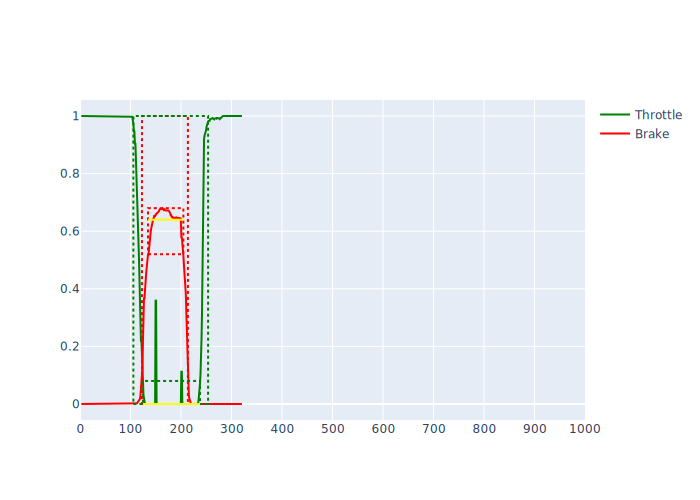

'time: 8.766667499999999 322 -> 578 / track: 1928.57'

"brake: {'start': 429.04, 'end': 475.01, 'max_start': 440.03, 'max_end': 452.03, 'max_high': 0.58, 'max_low': 0.52, 'force': 0.56, 'approach_speed': 37.56, 'min_speed': 29.11}"

"throttle: {'start': 417.05, 'end': 572.95, 'max_start': 430.04, 'max_end': 524.98, 'max_high': 0.09, 'max_low': 0.0, 'force': 0.01, 'approach_speed': 37.42, 'min_speed': 21.52}"

"gear: {'gear': 2, 'distance_gear': {322: 3, 499: 2}}"

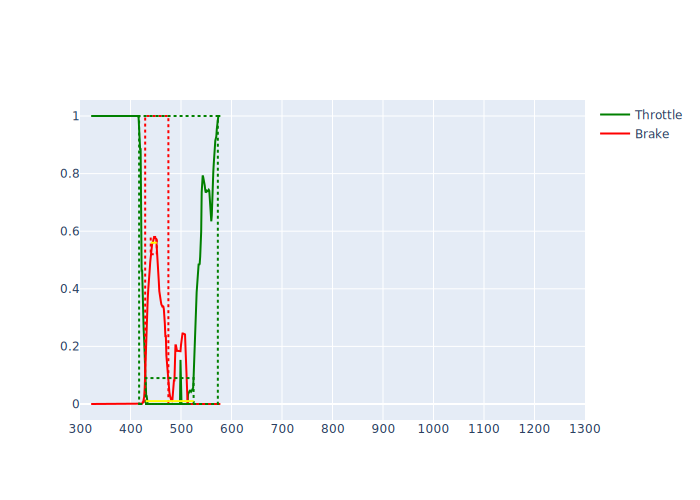

'time: 6.316667500000001 579 -> 770 / track: 1928.57'

'brake: {}'

"throttle: {'start': 579.51, 'end': 639.48, 'max_start': 580.51, 'max_end': 629.49, 'max_high': 0.8, 'max_low': 0.7, 'force': 0.77, 'approach_speed': 25.23, 'min_speed': 25.23}"

"gear: {'gear': 2, 'distance_gear': {580: 2}}"

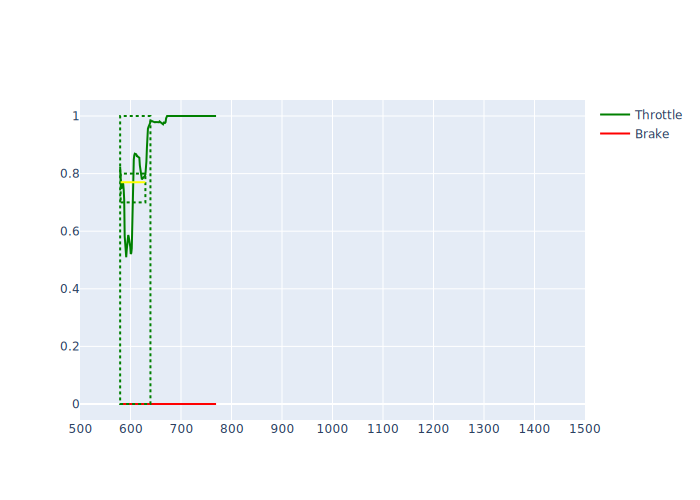

'time: 7.9166679 771 -> 1003 / track: 1928.57'

"brake: {'start': 871.7, 'end': 934.71, 'max_start': 880.7, 'max_end': 924.71, 'max_high': 0.63, 'max_low': 0.52, 'force': 0.6, 'approach_speed': 39.12, 'min_speed': 22.45}"

"throttle: {'start': 864.7, 'end': 966.72, 'max_start': 873.7, 'max_end': 958.72, 'max_high': 0.09, 'max_low': 0.0, 'force': 0.01, 'approach_speed': 39.12, 'min_speed': 18.26}"

"gear: {'gear': 1, 'distance_gear': {772: 2, 815: 3, 886: 2, 940: 1}}"

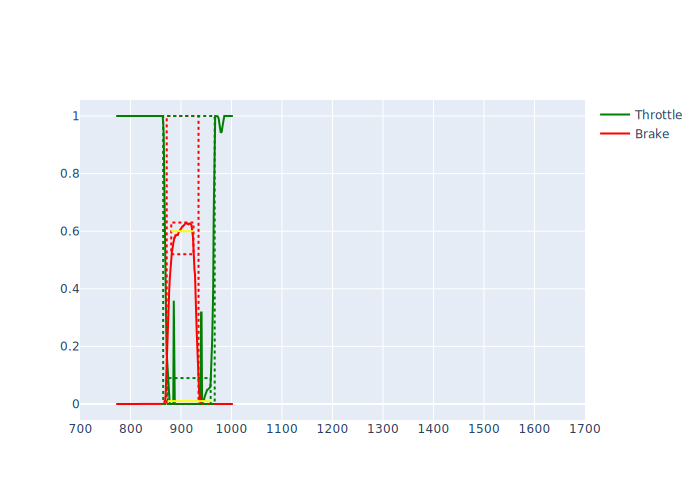

'time: 11.299997400000002 1004 -> 1308 / track: 1928.57'

"brake: {'start': 1039.51, 'end': 1068.51, 'max_start': 1039.51, 'max_end': 1067.51, 'max_high': 0.3, 'max_low': 0.11, 'force': 0.26, 'approach_speed': 27.08, 'min_speed': 21.14}"

"throttle: {'start': 1033.51, 'end': 1130.49, 'max_start': 1040.51, 'max_end': 1087.5, 'max_high': 0.05, 'max_low': 0.0, 'force': 0.0, 'approach_speed': 26.92, 'min_speed': 18.62}"

"gear: {'gear': 1, 'distance_gear': {1005: 1, 1193: 2, 1298: 3}}"

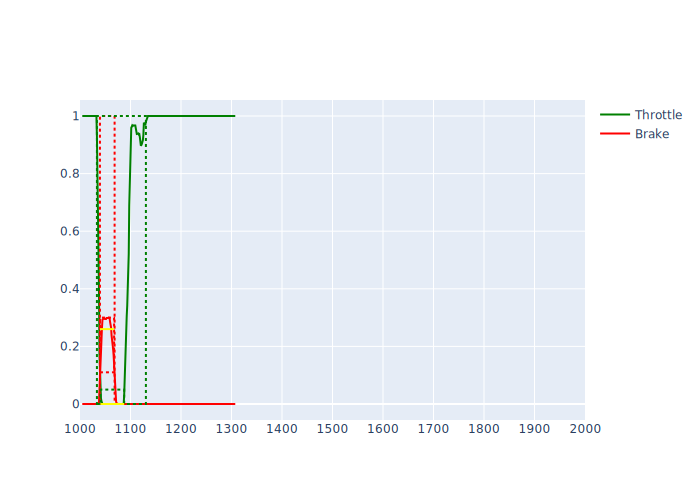

'time: 16.4 1309 -> 1928 / track: 1928.57'

"brake: {'start': 1406.9, 'end': 1449.88, 'max_start': 1417.9, 'max_end': 1441.89, 'max_high': 0.61, 'max_low': 0.5, 'force': 0.58, 'approach_speed': 39.84, 'min_speed': 30.78}"

"throttle: {'start': 1404.9, 'end': 1522.85, 'max_start': 1412.9, 'max_end': 1480.87, 'max_high': 0.08, 'max_low': 0.0, 'force': 0.01, 'approach_speed': 39.79, 'min_speed': 28.85}"

"gear: {'gear': 2, 'distance_gear': {1310: 3, 1432: 2, 1638: 3, 1856: 4}}"

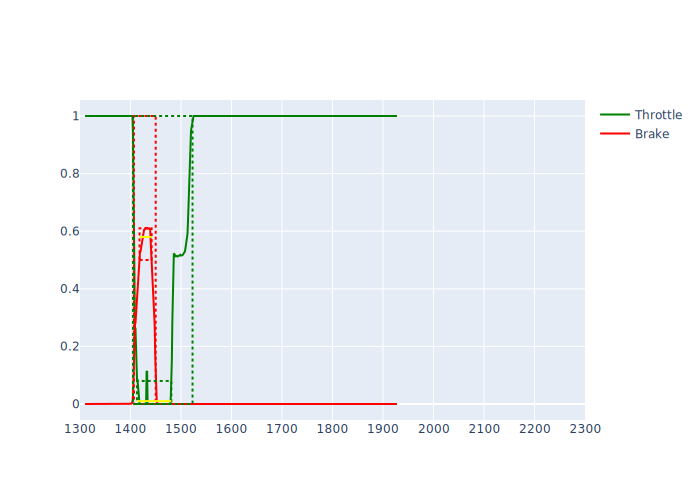

In [6]:
segments, used_laps = fast_lap_analyzer.extract_segments(sector_start_end, data_frames, laps_with_telemetry, df_max)
track_length = df_max["DistanceRoundTrack"].max()
for i in range(len(segments)):
    segment = segments[i]
    # display(segment.start, segment.end, segment.turn)
    # display(segment.telemetry)
    # df = telemetry_for_fig(segment)
    df = segment.telemetry
    fig = lap_fig(df, columns=["Throttle", "Brake"])
    brake_features = segment.brake_features()
    if brake_features:
        # brake_features = features_for_fig(segment, track_length, brake_features)
        fig_add_features(fig, brake_features)
    throttle_features = segment.throttle_features()
    if throttle_features:
        # throttle_features = features_for_fig(segment, track_length, throttle_features)
        fig_add_features(fig, throttle_features, color="green")
    display(f"time: {segment.time} {segment.start} -> {segment.end} / track: {segment.track_length}")
    display(f"brake: {segment.brake_features()}")
    display(f"throttle: {segment.throttle_features()}")
    display(f"gear: {segment.gear_features()}")
    fig.show()